<a href="https://colab.research.google.com/github/Jaew00/DeepLearning/blob/main/%EC%A4%91%EA%B0%84%EA%B3%BC%EC%A0%9C_CIFAR10_%EC%9D%B8%EC%8B%9D_%EC%A0%95%ED%99%95%EB%8F%84_%EC%B1%8C%EB%A6%B0%EC%A7%80_78__Colab_Py37.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri May 20 13:06:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    35W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from pyngrok import ngrok
ngrok.kill()

NGROK_AUTH_TOKEN = "28yZuvedFcMIsybQZEATgDjFFen_32ZNhDRPnr6UnxJeWhJeZ"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://d984-34-82-62-243.ngrok.io


In [50]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

from tqdm import tqdm
batch_size = 16
learning_rate = 0.002
num_epoch = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [51]:
import mlflow
import mlflow.sklearn
mlflow.set_experiment('ex03')

<Experiment: artifact_location='file:///content/mlruns/1', experiment_id='1', lifecycle_stage='active', name='ex03', tags={}>

In [52]:
def ComputeAccr(dloader, imodel, i):
  correct = 0
  total = 0

  for j, [imgs, labels] in enumerate(dloader) : 
    img = Variable(imgs, volatile = True).to(device) 

    label = Variable(labels).to(device)

    output = imodel.forward(img)
    _, output_index = torch.max(output, 1)

    total += label.size(0)
    correct += (output_index == label).sum().float()

  acc = 100*correct/total
  acc = float(acc.cpu().numpy())
  print("%dth Accuracy of Test Data: {}".format(acc) %i)
  return acc

In [53]:
cifar_train=dset.CIFAR10('CIFAR10/', train=True,
                         transform=transforms.Compose([
                          transforms.Resize(32),
                          transforms.ToTensor(),
                          transforms.Normalize(mean= (0.5, 0.5, 0.5),
                                               std=(0.5, 0.5, 0.5)),
                         ]),
                         target_transform=None, download=True)

cifar_test=dset.CIFAR10('CIFAR10/', train=False,
                         transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(mean= (0.5, 0.5, 0.5),
                                               std=(0.5, 0.5, 0.5)),
                         ]),
                         target_transform=None, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [54]:
train_loader = torch.utils.data.DataLoader(list(cifar_train)[:], 
                                           batch_size = batch_size, 
                                           shuffle = True,
                                           num_workers=2, 
                                           drop_last = True)
test_loader = torch.utils.data.DataLoader(cifar_test, 
                                          batch_size = batch_size, 
                                          shuffle = False,
                                          num_workers=2, 
                                          drop_last = True)


In [55]:
from torch.nn.modules.dropout import Dropout2d
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.conv import Conv2d


# ===== 4. 모델 선언 =====
class CNN(nn.Module) :
  def __init__(self) :
    super(CNN, self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(3, 8, 3, padding=1),
        nn.ELU(),
        #nn.Dropout2d(0.2),
        nn.BatchNorm2d(8),

        nn.Conv2d(8, 32, 3, padding=1),
        nn.ELU(),
        #nn.Dropout2d(0.2),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(32, 64, 3, padding=1),
        nn.ELU(),
        nn.Dropout2d(0.2),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2, 2),
    )

    self.fc_layer=nn.Sequential(
        nn.Linear(64 * 8 * 8, 1500),
        nn.ELU(),
        nn.Dropout2d(p=0.2),
        nn.BatchNorm1d(1500),
        nn.Linear(1500, 10),
    )
    
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
          init.kaiming_normal_(m.weight.data)
          m.bias.data.fill_(0)
      if isinstance(m, nn.Linear):
          init.kaiming_normal_(m.weight.data)
          m.bias.data.fill_(0)


  def forward(self, x):
    out = self.layer(x)
    out = out.view(batch_size, -1)
    out = self.fc_layer(out)

    return out

In [56]:
from torch.utils.tensorboard import SummaryWriter

def my_train(i_num_epoch, i_learning_rate) :
  loss_arr = []
  mlflow.end_run()
  with mlflow.start_run() :
    net_name = '/content/drive/MyDrive/Colab Notebooks/weights/best_weights6.pkl'

    #model = torch.load(net_name)
    model = CNN().to(device)
    loss_func = nn.CrossEntropyLoss().to(device)
    optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
    #scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-4)
    scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-4)
    max_acc = 0


    with SummaryWriter('runs') as writer :
      for i in range(i_num_epoch) :
        model = model.train()

        for j, [image, label] in enumerate(train_loader):
          x=Variable(image).to(device)
          y_=Variable(label).to(device)

          optimizer.zero_grad()
          output=model.forward(x)
          loss=loss_func(output,y_)
          loss.backward()
          optimizer.step()
          scheduler.step()

          if j%1000==0:
            print(j, loss)
            loss_arr.append(loss.cpu().detach().numpy())
            
        model.eval()    
        acc = ComputeAccr(test_loader, model, i)
        writer.add_scalar('accuracy', acc, i_num_epoch)

        if acc > max_acc :
          print("best acc updated:",acc)
          max_acc = acc
          torch.save(model, net_name)

      plt.plot(loss_arr)
      plt.show()
      print(max_acc)

      mlflow.log_param("epoch", i_num_epoch)
      mlflow.log_param("lr", i_learning_rate)
      mlflow.log_metric("accr", max_acc)
      mlflow.sklearn.log_model(model, "model")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0 tensor(3.1369, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.5835, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(1.7174, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(1.8763, device='cuda:0', grad_fn=<NllLossBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


0th Accuracy of Test Data: 63.2599983215332
best acc updated: 63.2599983215332
0 tensor(1.2456, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.3250, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(1.3260, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(1.2831, device='cuda:0', grad_fn=<NllLossBackward0>)
1th Accuracy of Test Data: 68.41999816894531
best acc updated: 68.41999816894531
0 tensor(1.2518, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.4157, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(1.4143, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(1.0149, device='cuda:0', grad_fn=<NllLossBackward0>)
2th Accuracy of Test Data: 72.5999984741211
best acc updated: 72.5999984741211
0 tensor(1.1820, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(0.6115, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(0.5757, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(0.5889, device='cuda:0', grad_fn=<NllLossBa

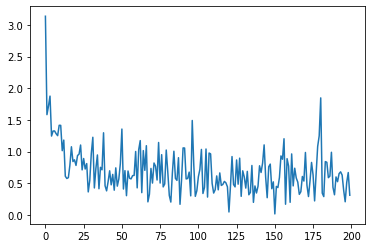

78.06999969482422


2022/05/20 13:59:28 WARNING mlflow.utils.requirements_utils: Found torch version (1.11.0+cu113) contains a local version label (+cu113). MLflow logged a pip requirement for this package as 'torch==1.11.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [57]:
my_train(i_num_epoch=num_epoch, i_learning_rate=learning_rate)

In [12]:
!mlflow ui

[2022-05-20 13:14:16 +0000] [14637] [INFO] Starting gunicorn 20.1.0
[2022-05-20 13:14:16 +0000] [14637] [INFO] Listening at: http://127.0.0.1:5000 (14637)
[2022-05-20 13:14:16 +0000] [14637] [INFO] Using worker: sync
[2022-05-20 13:14:16 +0000] [14640] [INFO] Booting worker with pid: 14640
[2022-05-20 13:14:19 +0000] [14637] [INFO] Handling signal: int

Aborted!
[2022-05-20 13:14:20 +0000] [14640] [INFO] Worker exiting (pid: 14640)
[2022-05-20 13:14:20 +0000] [14637] [INFO] Shutting down: Master


In [58]:
net_name = '/content/drive/MyDrive/Colab Notebooks/weights/best_weights6.pkl'
model = torch.load(net_name)
model.eval()    
acc = ComputeAccr(test_loader, model,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


1th Accuracy of Test Data: 78.06999969482422


In [60]:
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

SyntaxError: ignored